*updated 31 Dec 2024, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 3301 "Data Analysis in Ocean Sciences" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/academic-notes/tree/master/OCES3301_data_analysis_ocean) page.

In [1]:
# load some deafult packages

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, signal
from scipy.ndimage import filters, gaussian_filter
import pandas as pd
import urllib

---------------------------

# 07: Times series

Here the focus is on data with an associated time axis. Examples could include:

* Temperature of somewhere over some period.

* Whale calls (which has some pitch that varies in time).

* Phytoplankton concentration over some patch of ocean.

* Location of an eddy over time (this could be longitude/latitude as a function of time).

* Cursedness of a being with exposure to camera over time.

Time series analysis can serve as a whole course by itself (e.g. Jonathan Lilly's [time-series course](https://github.com/jonathanlilly/time-series)); see more examples there. We are only going to touch on a few tools here.

> NOTE: A lot of things visited here work equally well when the *space* variable is of concern. See *09/10_fun_with_maps*.

> NOTE: Through these two notebooks I am going to be using sines and cosines a lot, and by default when I am talking about the inputs of the sines and cosines I am going to be in units of radians. Most numerical programs expect arguments for trigonometric functions to be given in radians actually (Python is one of these). If you really insist on giving things in degrees, you could use the `np.deg2rad` function, which converts from degrees to radians.

> ## Key Objective(s)
> 1. Introduce time-series data as a 1d array and various operations that act on these.
> 2. Introduce various statistical quantities that could be calculated sensibly for time-series data.
> 3. Introduce the concept of power spectrum and how to interpret the relevant graphs.

---------------------
# a) Smoothing

In the case below I artificially created some time-series data (in this case 6-hourly) to manipulate. The below code just plots it (step -1 of data analysis: plot the data out and see what it looks like first). I am going to create a corresponding time array through the `np.datetime64` functionality.

> NOTE: For `datetime64`, if you want to create things in smaller or bigger units (e.g. seconds, days) you might do `np.timedelta64(1, 's')` or `np.timedelta64(1, 'd')`. Look up online for related syntax.

I'm not going to explain what the numbers are at the moment; see section d later for more details.

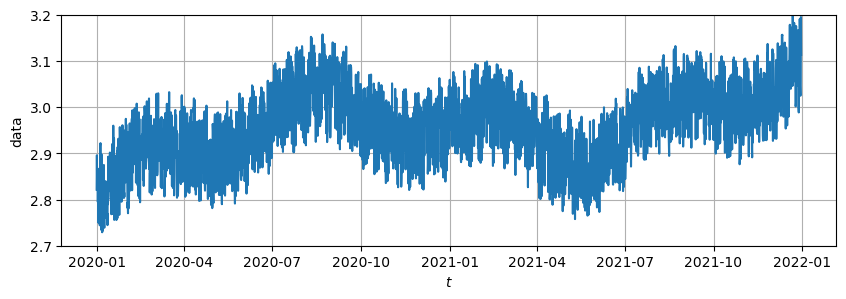

In [2]:
time_vec = np.arange(np.datetime64('2020-01-01'), np.datetime64('2021-12-31'), np.timedelta64(6, 'h'))

nt = len(time_vec)
t_vec = np.linspace(0, 2.0 * np.pi, nt)
lin_trend = 0.05 * np.linspace(0, 2.0 * np.pi, nt)

noise = 0.2 * np.random.rand(nt)
f_vec = (  2.7 
         + 0.1 * np.sin(t_vec) 
         + 0.05 * np.sin(4.0 * t_vec) 
         + 0.02 * np.sin(60.0 * t_vec) 
         + lin_trend 
         + noise
        )

fig = plt.figure(figsize=(10, 3))
ax = plt.axes()
ax.plot(time_vec, f_vec, 'C0-')
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"data")
ax.set_ylim([2.7, 3.2])
ax.grid()

(Remember this guy?)

<img src="https://i.imgur.com/rRDngzC.jpg" width="400" alt='haku'>

So I cooked up this time-series to have suggestions of features (e.g. longer time oscillations), but the graph is very dense with lots of points, which is potentially masking out a lot of the information. We could zoom in a little bit.

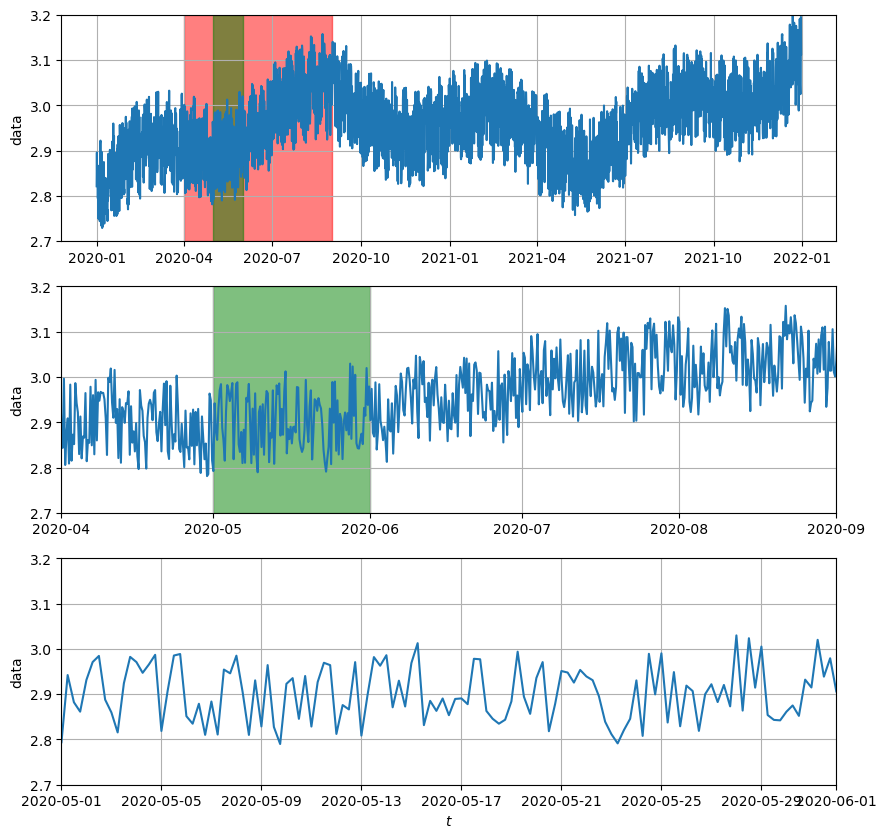

In [3]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 1, 1)
ax.plot(time_vec, f_vec, 'C0-')
# ax.set_xlabel(r"$t$")
ax.set_ylabel(r"data")
ax.set_ylim([2.7, 3.2])
plt.axvspan(np.datetime64('2020-04'), np.datetime64('2020-09'), color='red', alpha=0.5)
plt.axvspan(np.datetime64('2020-05'), np.datetime64('2020-06'), color='green', alpha=0.5)
ax.grid()

ax = plt.subplot(3, 1, 2)
ax.plot(time_vec, f_vec, 'C0-')
# ax.set_xlabel(r"$t$")
ax.set_ylabel(r"data")
ax.set_ylim([2.7, 3.2])
ax.set_xlim([np.datetime64('2020-04'), np.datetime64('2020-09')])
plt.axvspan(np.datetime64('2020-05'), np.datetime64('2020-06'), color='green', alpha=0.5)
ax.grid()

ax = plt.subplot(3, 1, 3)
ax.plot(time_vec, f_vec, 'C0-')
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"data")
ax.set_ylim([2.7, 3.2])
ax.set_xlim([np.datetime64('2020-05'), np.datetime64('2020-06')])
ax.grid()

There seems to be some long term trend going up, as well as some oscillations at different **periods** (because I put it in afterall).

> <span style="color:red">**Q.**</span> (semi-theoretical) The code actually gives you enough information to tell you what the period is, so what are they in units of days/months say?

There is however also noise (because I also put some in), and the task here is to try and pull that out the "signals" of interest in some way. One way we could do is to just brute force **downsize** the data, i.e., plot the data every so often (we will come back to this in *09_fun_with_maps*). The below code is an example of this; have a think what I actually did below.

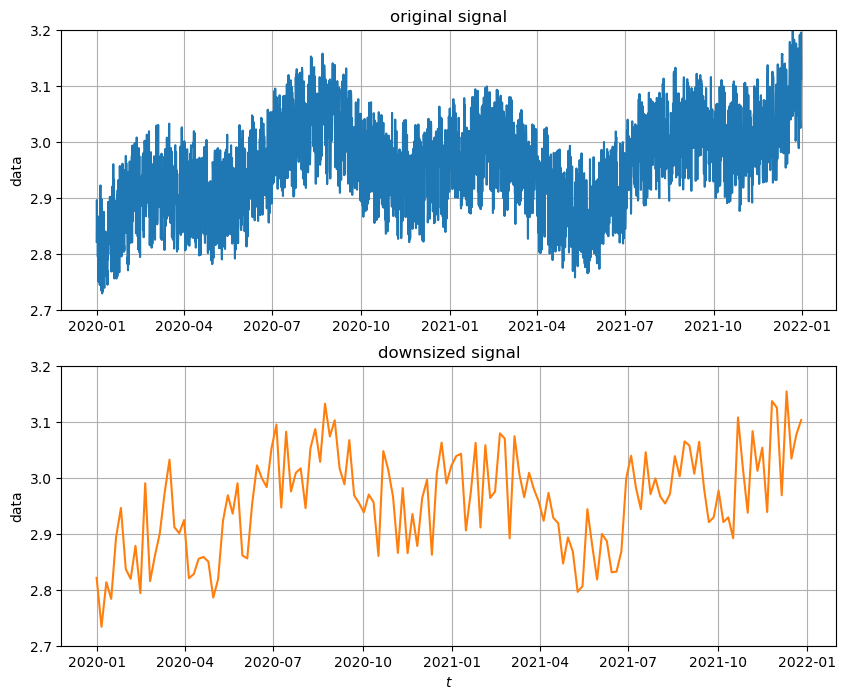

In [4]:
fig = plt.figure(figsize=(10, 8))

ax = plt.subplot(2, 1, 1)
ax.plot(time_vec, f_vec, 'C0-')
# ax.set_xlabel(r"$t$")
ax.set_ylabel(r"data")
ax.set_ylim([2.7, 3.2])
ax.set_title("original signal")
ax.grid()

ax = plt.subplot(2, 1, 2)
ax.plot(time_vec[::20], f_vec[::20], 'C1-')  # downsizing is here: what am I doing?
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"data")
ax.set_ylim([2.7, 3.2])
ax.set_title("downsized signal")
ax.grid()

The above procedure makes the plot less cluttered, but it doesn't really tell us much more that what we can see already, and there are still a lot of fluctuations going on. We may want to somehow **filter** those out.

Formally, filtering a time-series $f(t)$ involves performing a **convolution** with a **kernel function** $G(t)$. The filtered time series I am denoting $f^{<}(t)$ is given by

\begin{equation*}
    f^{<}(t) = (f\ *\ G)(t) = \int f(\tau)G(t - \tau)\; \mathrm{d}\tau,
\end{equation*}

where $\tau$ is a dummy time variable, and the integral is taken over the whole time of the signal. Here I am specifically thinking of a **low-pass filter**, where the filtering process keeps the lower frequencies (longer periods) and smooths out the higher frequencies (shorter periods); hence the notation $f^{<}(t)$, because we are keeping the lower frequencies.

> NOTE: You can of course define a **high-pass filter** analogously, either through an appropriate definition of $G$, taking $f^{>} = f - f^{<}$, or something else. We are mostly going to focus on low-passes here.

A perhaps illustrative example is that of **averaging over a moving time window**. I take some point in time $t_0$, consider a window around this point $(t_0 - T/2, t_0 + T/2)$, average all the values within the window, and call this the value of the filtered time-series. If we are assuming the data is constantly spaced in time $\Delta t$, then we would have

\begin{equation*}
    f^{<}(t_0) = \frac{1}{T}\int^{t_0 + T/2}_{t_0 - T/2} f(\tau)\; \mathrm{d}\tau \approx \frac{f_1 + f_2 + \cdots + f_N}{N},
\end{equation*}

where $f_1 = f(t_0 - T/2)$, $f_2 = f(t_0 - T/2 + \Delta t)$, ... $f_{N-1} = f(t_0 + T/2 - \Delta t)$, $f_N = f(t_0 + T/2)$, and we do this for every $t_0$ choice. 

> NOTE: The above turns into a simple average only because of the assumption of constant spacing in time. If that is not true in your data, you have to do a numerical integral (sometimes called a **quadrature**) for the data to be weighed properly.
>
> (To confuse you a bit, a quadrature happens to be a weighted sum that is an approximation to the integral. When we are dealing with numerical data, we are almost always doing sums and products.)

Equivalently, this is setting the kernel to be

\begin{equation*}
    G(\tau) = \begin{cases} 1/T & t - T/2 \leq \tau \leq t + T/2, \\ 0 & \mathrm{otherwise}\end{cases}.
\end{equation*}

See if the animation I made helps: the last value of the filtered signal in the top panel is obtained from averaging over the data in the green window.

<img src="https://i.imgur.com/jD0HnE8.gif" width="600" alt='moving window'>

The code below gives you the end result straight away, and overlays the original signal and the filtered signal.

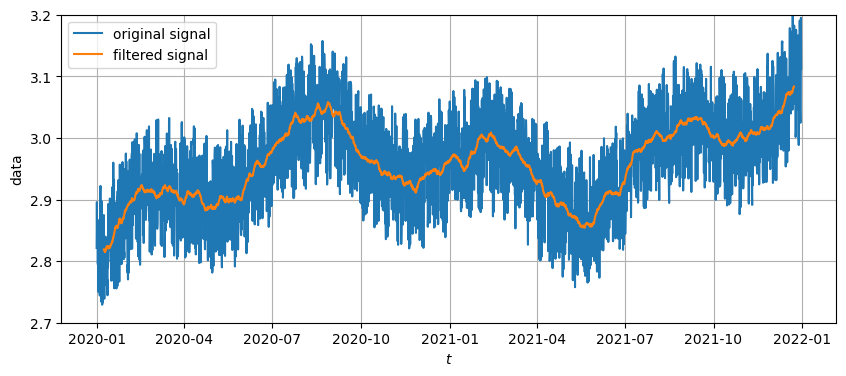

In [5]:
window = 60                                             # specify a window (number of entries)
half_window = int(window / 2)

f_filter = []   # initialise lists and dump into them
t_filter = []
for i in range(half_window, len(f_vec) - half_window):
    t_filter.append(time_vec[i])
    f_filter.append(np.mean(f_vec[i-half_window:i+half_window]))
    
fig = plt.figure(figsize=(10, 4))

ax = plt.axes()
ax.plot(time_vec, f_vec, 'C0-', label="original signal")
ax.plot(t_filter, f_filter, 'C1-', label="filtered signal")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"data")
ax.set_ylim([2.7, 3.2])
ax.grid()
ax.legend()

Notice the averaging in this case removes the high-frequency (short period) fluctuations without down sampling; the data array size is comparable to the beginning. The signal has decreased in magnitude, because we are dealing with an averaging procedure, which by default removes the extremes in values. 

For the low-passed signal, we can perhaps see that there is a robust oscillation with a six month period, as well as hints of an oscillation over 24 months (less obvious because of the linear trend, because the data is identified over a time period of only 24 months anyway; convince yourself the oscillations I put in to this artificial time-series are exactly the ones I said above.
   
> NOTE: The averaging procedure I did chops off some end points. There are ways around this, though you might just need to be careful what packages actually do for the end points.
   
> <span style="color:red">**Q.**</span> I chose `window = 60`, but what does this actually mean in terms of time units? Or, put another way, what is the averaging window (lets say in days) I am choosing? With this, convince yourself that the choice of `window = 60` severely damps one of the shorter period / higher frequencies I put in by hand when creating the signal.

> <span style="color:red">**Q.**</span> Try playing around with the window size and see the effects.

> <span style="color:red">**Q.**</span> (Needs a bit of care) Remove the low-passed signal from the original signal to get the analogous high-pass signal. Is the signal what you expected?

You don't have to use a uniform window. The below example uses a **tent kernel**. Instead of weighting all the values uniformly as above (through the use of `np.mean`), I could for example say I care more about the values near the $t_0$ location, and progressively care less as I move away, eventually going to zero. The below code is one demonstration of the tent kernel in action.

> NOTE: The kernels that go to zero within some finite time in this setting would be an example of a kernel with **compact support**. 

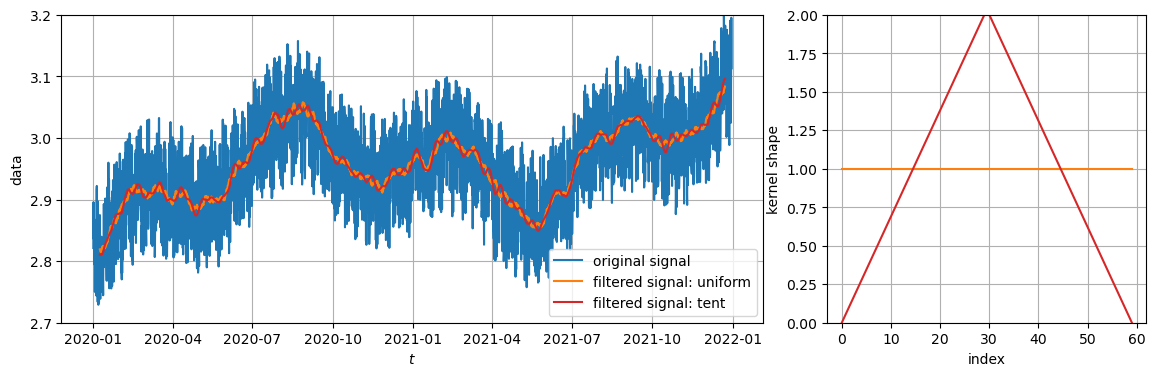

In [6]:
window = 60                                             # specify a window (number of entries)
half_window = int(window / 2)

tent_kernel  = -np.abs(np.arange(window)+0.5 - window/2.0)   # make a straight line and bend it into a v
tent_kernel -= np.min(tent_kernel)                           # flip the v upside down
tent_kernel /= np.max(tent_kernel) / 2.0                     # normalise such that kernel integrates to window size
                                                             #   so multiplcation then followed by np.mean leads
                                                             #   to no damping as such

f_filter2 = []   # initialise lists and dump into them
t_filter = []
for i in range(half_window, len(f_vec) - half_window):
    t_filter.append(time_vec[i])
    f_filter2.append(np.mean(tent_kernel * f_vec[i-half_window:i+half_window]))
    
fig = plt.figure(figsize=(14, 4))
ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax.plot(time_vec, f_vec, 'C0-', label="original signal")
ax.plot(t_filter, f_filter,  'C1-', label="filtered signal: uniform")
ax.plot(t_filter, f_filter2, 'C3-', label="filtered signal: tent")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"data")
ax.set_ylim([2.7, 3.2])
ax.grid()
ax.legend()

ax = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax.plot(np.ones(len(tent_kernel)), 'C1-', label="uniform kernel")
ax.plot(tent_kernel, 'C3-', label="tent kernel")
ax.set_xlabel(r"index")
ax.set_ylabel(r"kernel shape")
ax.set_ylim([0.0, 2.0])
ax.grid()

The filtered signal resulting from the tent kernel visually keeps a bit more of the fluctuations; this could be quantified more in the frequency domain (see *08_time_series*).

Another popular filter to use is the **Gaussian filter** and, you might have guessed from the name, the kernel function is the Gaussian function, which you have seen in *05_statistical_tests*. Instead of a window, a Gaussian filter width is related some specified standard deviation. The Gaussian kernel formally is **non-compact**, although in practice there is usually a default chop off of the kernel after a certain range, because otherwise the convolution procedure (which is an integral, so numerically these are sums) becomes computational expensive to carry out.

The below is an example of a Gaussian filter through `scipy.ndimage.filters` (not going to bother coding this from scratch, but you could if you want some Python practice...)

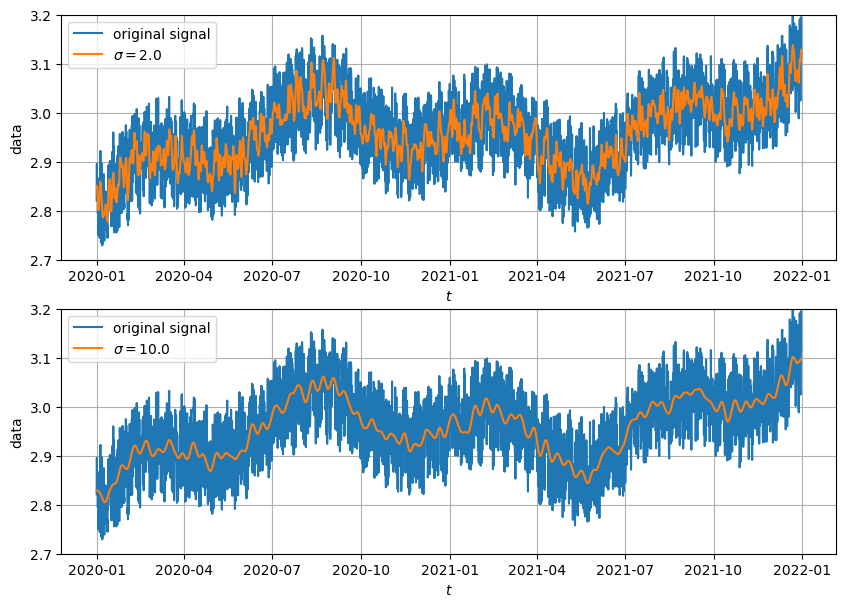

In [7]:
# default is 1d Gaussian (reshape data into n-d to do n-d filtering)

sigma = 2.0  # here the value to specify is sigma, which determines kernel shape
f_vec_gauss_avg = gaussian_filter(f_vec, sigma)

fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(2, 1, 1)
ax.plot(time_vec, f_vec, 'C0-', label="original signal")
ax.plot(time_vec, f_vec_gauss_avg, 'C1-', label=r"$\sigma = %.1f$" % sigma)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"data")
ax.set_ylim([2.7, 3.2])
ax.grid()
ax.legend()

sigma = 10.0
f_vec_gauss_avg = gaussian_filter(f_vec, sigma)
ax = plt.subplot(2, 1, 2)
ax.plot(time_vec, f_vec, 'C0-', label="original signal")
ax.plot(time_vec, f_vec_gauss_avg, 'C1-', label=r"$\sigma = %.1f$" % sigma)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"data")
ax.set_ylim([2.7, 3.2])
ax.grid()
ax.legend()

> <span style="color:red">**Q.**</span> Why is the latter result more smooth?

> <span style="color:red">**Q.**</span> Why does this not need `time_vec` to be reduced in size? Look up what the Gaussian filter default is at the edges of the data array.

The above are just some examples of smoothing procedures, and are by no means exhaustive (e.g. **wavelets**, see exercise here). We will revisit aspects of this part again once we talked a bit about the frequency domain and the spectrum in *08_time_series*.

----------------------
# b) Trends

Generically this would mean the **linear trend**, which is the slope of the linear regression of the data (i.e. $a$ in the regressed model $y = f(t) = at + b$). The slope/trend $a$ tells you how $y$ changes with every factor of $t$. For example, if I had

\begin{equation*}
    {\rm cursedness} = 0.7\ ({\rm length\ of\ camera\ exposure}) + 1.0,
\end{equation*}

and I measure cursedness in units of micro-cathulu ($\mu{\rm Cat} = 10^{-6}\ {\rm Cat}$) and length of camera exposure in the SI unit seconds (${\rm s}$), then my (linear) trend here would be $0.7 \mu{\rm Cat}\ \mathrm{s}^{-1}$.

<img src="https://i.imgur.com/OPae3B2.jpg" width="600" alt='100 micro-cat and a non-cursed cat'>

We could look at this for the artificial time-series as well as its low-passed version above. In this case we know exactly what the trend is supposed to be, because we made the time-series (what is it?)

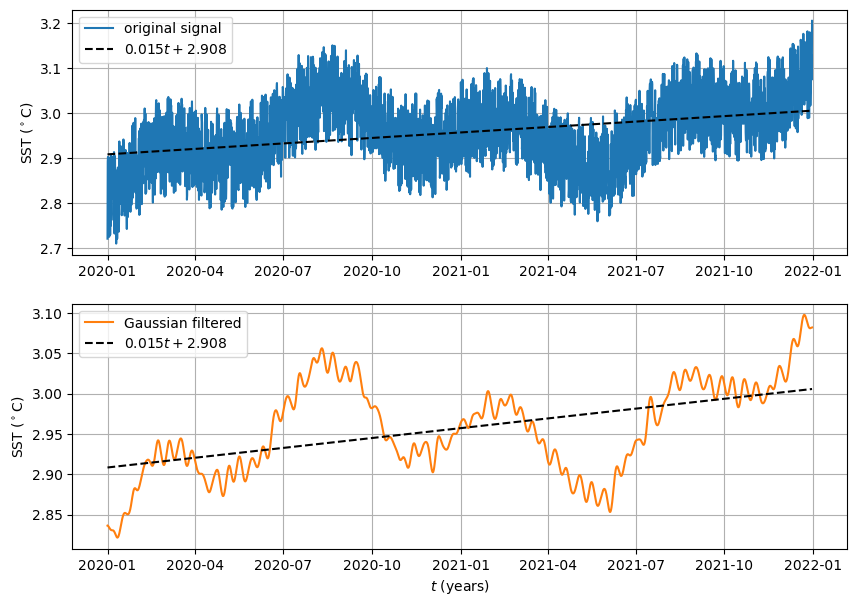

In [8]:
# re-create the time-series for easier referencing

nt = len(time_vec)
t_vec = np.linspace(0, 2.0 * np.pi, nt)
lin_trend = 0.05 * np.linspace(0, 2.0 * np.pi, nt)

noise = 0.2 * np.random.rand(nt)
f_vec = (  2.7 
         + 0.1 * np.sin(t_vec) 
         + 0.05 * np.sin(4.0 * t_vec) 
         + 0.02 * np.sin(60.0 * t_vec) 
         + lin_trend 
         + noise
        )

f_vec_gauss_avg = gaussian_filter(f_vec, 10)

p_orig  = np.polyfit(t_vec, f_vec, 1)
p_gauss = np.polyfit(t_vec, f_vec_gauss_avg, 1)

fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(2, 1, 1)
ax.plot(time_vec, f_vec, label=r"original signal")
ax.plot(time_vec, np.polyval(p_orig, t_vec), 'k--',  # regressed linear trend
        label=f"${{{p_orig[0]:.3f}}} t + {{{p_orig[1]:.3f}}}$")  
ax.set_ylabel(r"SST (${}^\circ\mathrm{C}$)")
ax.grid()
ax.legend()

ax = plt.subplot(2, 1, 2)
ax.plot(time_vec, f_vec_gauss_avg, "C1-", label=r"Gaussian filtered")
ax.plot(time_vec, np.polyval(p_gauss, t_vec), 'k--',  # regressed linear trend
        label=f"${{{p_gauss[0]:.3f}}} t + {{{p_gauss[1]:.3f}}}$")  
ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"SST (${}^\circ\mathrm{C}$)")
ax.grid()
ax.legend()

It is reassuring here that the filtering ends up preserving the trends, because that is not an obvious property of the filter (or is it?)

> <span style="color:red">**Q.**</span> (Mathematical) Is it provable property that filters preserve the linear trends? Try and search the internet and see if there is any info on this. You could also try some numerical experiments, though that itself would not be a proof.

> <span style="color:red">**Q.**</span> The second coefficient (the constant) should be `2.7` because that's what I used to create the time-series, however the linear regression does not give that. Is this a problem? Why?

> <span style="color:red">**Q.**</span> The slope I gave the linear trend was `0.05`, but the value from the regression is not that. The answer is actually correct, but why? (Hint: what is time here?)

**De-trending** in this case just means removing the (linear) trend from the signal, which is done below (notice the difference in the axes values). The resulting signal is sometimes called the **anomalies** (relative to the linear trend).

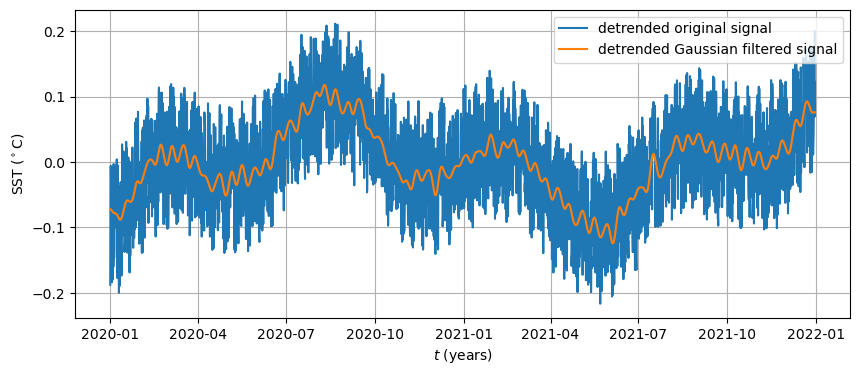

In [9]:
fig = plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.plot(time_vec, f_vec - np.polyval(p_orig, t_vec), label=r"detrended original signal")
ax.plot(time_vec, f_vec_gauss_avg - np.polyval(p_gauss, t_vec), "C1-", label=r"detrended Gaussian filtered signal")
ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"SST (${}^\circ\mathrm{C}$)")
ax.grid()
ax.legend()

There is of course the possibility of obtaining and/or removing the quadratic trends etc.

----------------------
# c) Correlations

Just like we could ask about the correlation between two datasets (e.g. *03_regression*), we could ask how two signals are correlated in (almost) exactly the same way. Below I am going to use artificial data to make a few points in cases where where we should basically know the answer before we even ask the computer to do stuff for us. The lines we are plotting here are (for $0 \leq t \leq 2\pi$)

\begin{equation*}
    f(t) = \sin(t), \qquad f^+ = 2 \sin(t), \qquad f^- = -\sin(t), \qquad f_{\rm shift} = \sin\left(t - \frac{\pi}{2}\right)
\end{equation*}

> <span style="color:red">**Q.**</span> What correlations do you expect the signals are relative to $f$? Try and give your answer without running the code below.

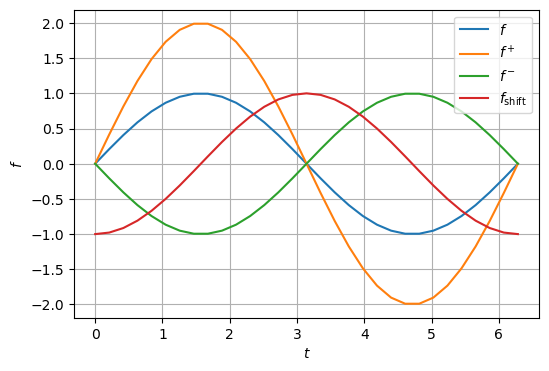

In [10]:
t_vec   = np.linspace(0, 2.0 * np.pi, 31)
f       =   np.sin(t_vec)
f_pos   = 2*np.sin(t_vec)
f_neg   =  -np.sin(t_vec)
f_shift =   np.sin(t_vec - np.pi / 2.0)

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.plot(t_vec, f    ,   "C0", label=r"$f$")
ax.plot(t_vec, f_pos,   "C1", label=r"$f^+$") 
ax.plot(t_vec, f_neg,   "C2", label=r"$f^-$")
ax.plot(t_vec, f_shift, "C3", label=r"$f_{\rm shift}$")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$f$")
ax.grid()
ax.legend()

It might be clearer if we plot the various signals directly against $f$ in a scatter graph.

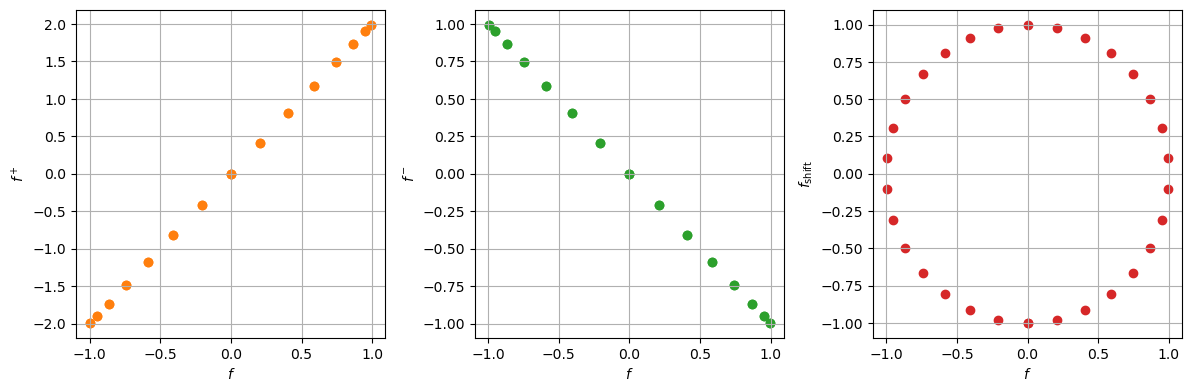

In [11]:
# same as above but as scatter graph

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 3, 1)
ax1.scatter(f, f_pos, color="C1")
ax1.set_xlabel(r"$f$")
ax1.set_ylabel(r"$f^+$")
ax1.grid()

ax2 = plt.subplot(1, 3, 2)
ax2.scatter(f, f_neg, color="C2")
ax2.set_xlabel(r"$f$")
ax2.set_ylabel(r"$f^-$")
ax2.grid()

ax3 = plt.subplot(1, 3, 3)
ax3.scatter(f, f_shift, color="C3")
ax3.set_xlabel(r"$f$")
ax3.set_ylabel(r"$f_{\rm shift}$")
ax3.grid()

fig.tight_layout(pad=1.0) # give the graph a bit of padding

Now you know what the answer you should be getting, lets see if the direct computations will be reproducing those. I am going to be using the `scipy.stats` package for this, but you could use `scikit-learn` or even brute force computing the (Pearson/linear) correlation coefficient if you want.

In [12]:
_, _, r_pos, _, _ = stats.linregress(f, f_pos)
_, _, r_neg, _, _ = stats.linregress(f, f_neg)
_, _, r_shift, _, _ = stats.linregress(f, f_shift)

print(f"f and f_pos   has (linear/Pearson) correlation coefficient of {r_pos:.2f}")
print(f"f and f_neg   has (linear/Pearson) correlation coefficient of {r_neg:.2f}")
print(f"f and f_shift has (linear/Pearson) correlation coefficient of {r_shift:.2f}")

f and f_pos   has (linear/Pearson) correlation coefficient of 1.00
f and f_neg   has (linear/Pearson) correlation coefficient of -1.00
f and f_shift has (linear/Pearson) correlation coefficient of 0.00


## Cross correlation

Going to focus on the shifted signal above. Below is the same example but extended in the $t$ variable.

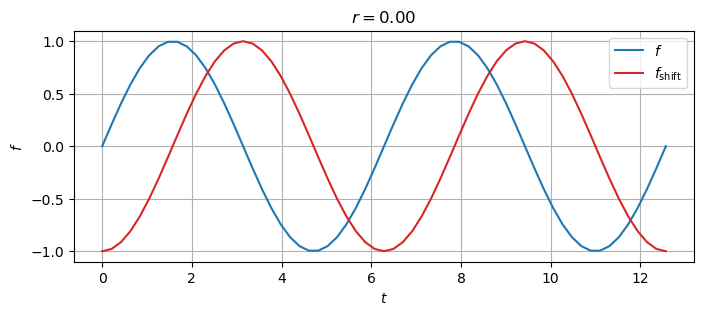

In [13]:
t_vec   = np.linspace(0, 4.0 * np.pi, 61)
f       =   np.sin(t_vec)
f_shift =   np.sin(t_vec - np.pi / 2.0)

_, _, r_shift, _, _ = stats.linregress(f, f_shift)

fig = plt.figure(figsize=(8, 3))
ax = plt.axes()
ax.plot(t_vec, f    ,   "C0", label=r"$f$")
ax.plot(t_vec, f_shift, "C3", label=r"$f_{\rm shift}$")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$f$")
ax.grid()
ax.legend()
ax.set_title(f"$r = {r_shift:.2f}$");

By construction there is no linear correlation between the signals, but doing the all important step -1 of data analysis (plotting the data out and just looking at it) will tell you there is clearly some correlation between the two, particularly if we choose to **lag** the signals. Below I am shifting the data and then computing the $r$-value again.

> NOTE: In the way I am doing the shift you need to make sure the signal is of the same length, which means some chopping of the signals are required.

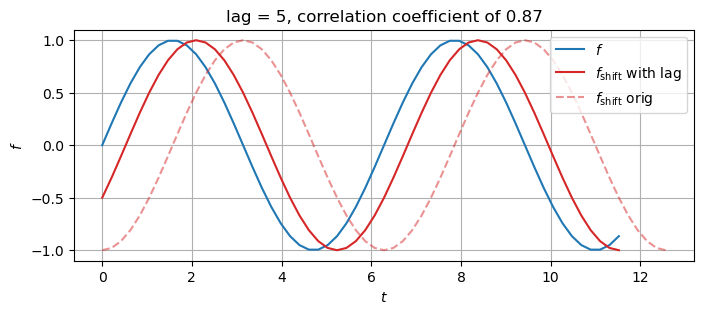

In [14]:
lag = 5  # lag by 5 indices

_, _, r_lag, _, _ = stats.linregress(f[:-lag:], f_shift[lag::])  # chop the signal

fig = plt.figure(figsize=(8, 3))
ax = plt.axes()
ax.plot(t_vec[:-lag:], f      [:-lag:]    ,   "C0", label=r"$f$")
ax.plot(t_vec[:-lag:], f_shift[lag::], "C3", label=r"$f_{\rm shift}$ with lag")
ax.plot(t_vec, f_shift, "C3--", label=r"$f_{\rm shift}$ orig", alpha=0.5)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$f$")
ax.grid()
ax.legend()
ax.set_title(f"lag = {lag}, correlation coefficient of {r_lag:.2f}");

Having done the mantra of "trying small before going big", the below subroutine performs a **cross correlation analysis** (which is a product from the **lagged regressions**) of the two signals.

> NOTE: I have included an example of a **error catching** in the subroutine below that may or may not be of interest.

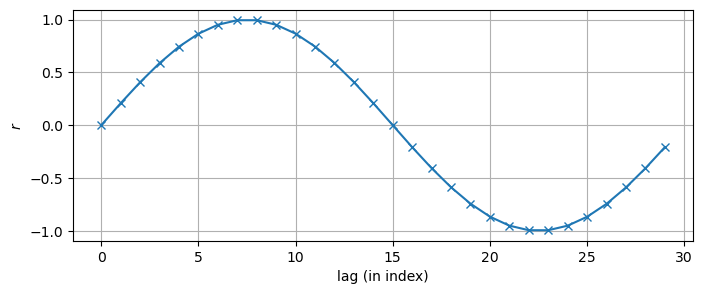

In [15]:
def custom_lag_corr(signal1, signal2, lag):
    if len(signal1) != len(signal2):
        raise Exception("array size not equal, cannot continue")

    if lag == 0:
        _, _, r, _, _ = stats.linregress(signal1, signal2)
    else:
        _, _, r, _, _ = stats.linregress(signal1[:-lag:], signal2[lag::])
    
    return r

n = 30
r_lag = np.zeros(n)
for lag in range(n):
    r_lag[lag] = custom_lag_corr(f, f_shift, lag)

fig = plt.figure(figsize=(8, 3))
ax = plt.axes()
ax.plot(np.arange(n), r_lag, "C0-x")
ax.set_xlabel(r"lag (in index)")
ax.set_ylabel(r"$r$")
ax.grid()

Notice that if the value of $n$ (the extent of the lag) gets too big, the number of samples to calculate the correlation becomes small, and it would increasingly become a dodgy manoeuvre (hence why I extended the signal by another period). In the present case this is not really an issue because the signal is very clean, but is often not the case with a "real" signal.

In the above the lag is given per `index`, although we might be interested in what that corresponds to in "real" time. What needs to be done here is finding out what `lag = 1` actually means (it's really just a change of units). In this case I can get that from the time array by taking differences of the time vector, and since I also know the time array is uniform in time, I only need one of the entries, so might as well pick the first one.

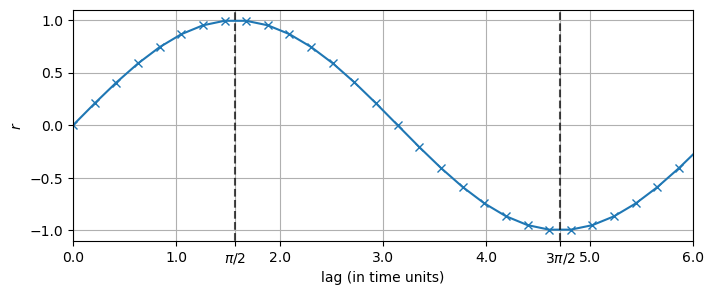

In [16]:
dt = np.diff(t_vec)[0]

fig = plt.figure(figsize=(8, 3))
ax = plt.axes()
ax.plot(np.arange(n) * dt, r_lag, "C0-x")
ax.plot([np.pi / 2, np.pi / 2], [-2, 2], "k--", alpha=0.7)          # theoretical maximum
ax.plot([3 * np.pi / 2, 3 * np.pi / 2], [-2, 2], "k--", alpha=0.7)  # theoreical minimum
ax.set_xlabel(r"lag (in time units)")
ax.set_ylabel(r"$r$")
ax.set_ylim([-1.1, 1.1])
ax.grid()

# add the tick labels in
xt = ax.get_xticks() 
xt = np.append(xt, [np.pi/2, 3*np.pi/2])
xtl= xt.tolist()
xtl[-2]=r"$\pi/2$"
xtl[-1]=r"$3\pi/2$"
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.set_xlim([0, 6]);

> <span style="color:red">**Q.**</span> Are the answers here consistent and what you expected?

> <span style="color:red">**Q.**</span> There is `np.correlate` that could do something similar. Look up the syntax of that function and try using that too.

## Auto-correlation

You could choose two different signals, or the same signal twice, appropriately shifted. A cross-correlation analysis like the above for the same signal is called an **auto-correlation** ("auto" $\leftrightarrow$ "self"), and is a measure of how related the signal is to lagged versions of itself. The below is one an example of the **auto-correlation function (ACF)**, using the sine curve example just now.

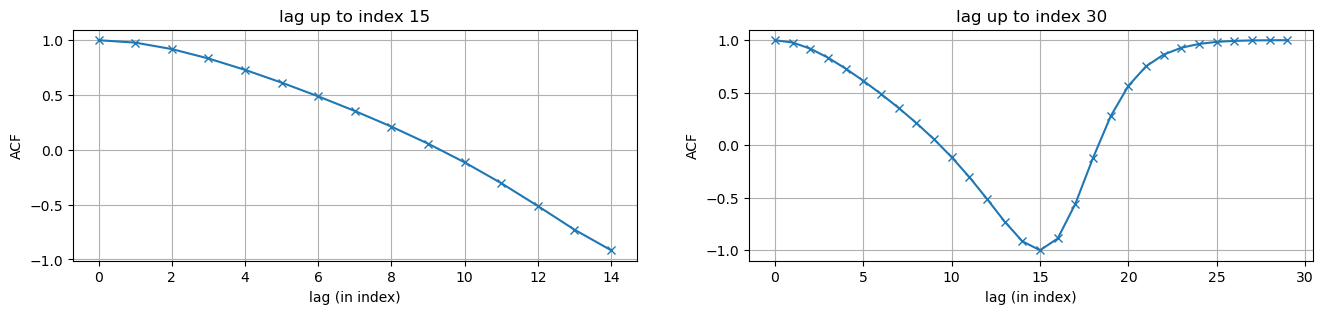

In [17]:
# trivial example

t_vec = np.linspace(0, 2.0 * np.pi, 31)
f     = np.sin(t_vec)
dt = np.diff(t_vec)[0]

fig = plt.figure(figsize=(16, 3))

n = 15
r_lag = np.zeros(n)
for lag in range(n):
    r_lag[lag] = custom_lag_corr(f, f, lag)
    
ax = plt.subplot(1, 2, 1)
ax.plot(np.arange(n), r_lag, "C0-x")
ax.set_xlabel(r"lag (in index)")
ax.set_ylabel(r"ACF")
ax.set_title(f"lag up to index {n}")
ax.grid()

n = 30
r_lag = np.zeros(n)
for lag in range(n):
    r_lag[lag] = custom_lag_corr(f, f, lag)
    
ax = plt.subplot(1, 2, 2)
ax.plot(np.arange(n), r_lag, "C0-x")
ax.set_xlabel(r"lag (in index)")
ax.set_ylabel(r"ACF")
ax.set_title(f"lag up to index {n}")
ax.grid()

> <span style="color:red">**Q.**</span> Are the answers here consistent and what you expected? Maybe plot out the actual signal and the lags to convince yourself the code is doing what it is supposed to do.

> <span style="color:red">**Q.**</span> This is a sine/cosine curve and the lag correlations should be symmetric, but the right panel is not symmetric about the minimum point, why? (Hint: what is the size of array and what is the lag?)

> <span style="color:red">**Q.**</span> With the above answer, think of a way (or several ways) to get rid of that above offending reason and show that one can get a symmetric auto-correlation.

Oscillations in the ACF would be indicative of periodic behaviour. ACF also gives you a measure of how predictable the signal is: if the ACF is high for a while, then knowing the value at one point gives you an indication several points ahead, whilst a fast drop indicates the signal decorrelates with itself and loses predictability quickly.

The ACF I did above is just a lag-correlation, where the correlation is normalised by the *sample* mean and variances, which changes as I change the magnitude of the lag, because I end up chopping bits of the signal out as I do the lag correlation. There are packages that have the ACF built in (e.g. `statsmodel` package), but in some cases the ACF is normalised by the *population* mean and variance of the whole, or have some other properties in there, so you might just need to be careful (it's always good to know multiple ways of doing the same thing).

Below is calculating the ACF through `pandas`, which uses `np.correlate`, and is done exactly like the way I did it above.

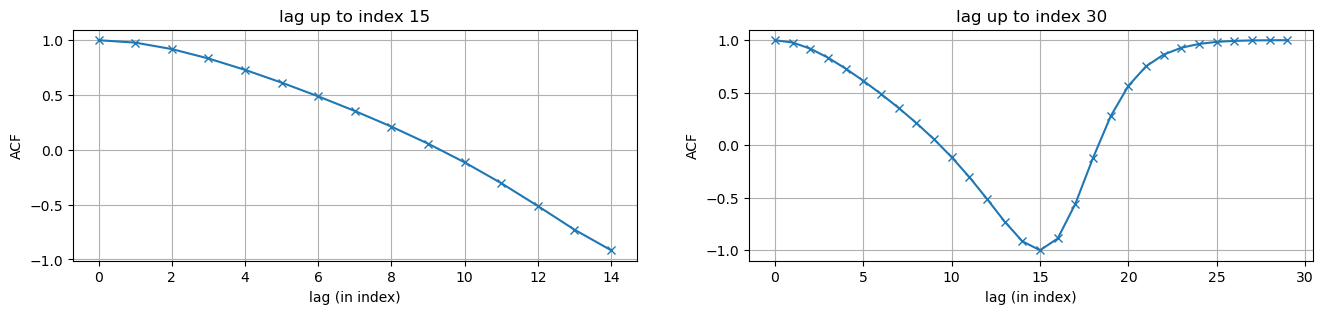

In [18]:
s = pd.Series(f)
n = 30
acf = np.zeros(n)

fig = plt.figure(figsize=(16, 3))

n = 15
acf = np.zeros(n)
for lag in range(n):
    acf[lag] = s.autocorr(lag=lag)
    
ax = plt.subplot(1, 2, 1)
ax.plot(np.arange(n), acf, "C0-x")
ax.set_xlabel(r"lag (in index)")
ax.set_ylabel(r"ACF")
ax.set_title(f"lag up to index {n}")
ax.grid()

n = 30
acf = np.zeros(n)
for lag in range(n):
    acf[lag] = s.autocorr(lag=lag)
    
ax = plt.subplot(1, 2, 2)
ax.plot(np.arange(n), acf, "C0-x")
ax.set_xlabel(r"lag (in index)")
ax.set_ylabel(r"ACF")
ax.set_title(f"lag up to index {n}")
ax.grid()

> NOTE: If you use the `acf` function in `statsmodel` you will find the ACF is calculated differently and by default decays with lag. It also provides things like confidence intervals and other fancy things. If you are interested, try and follow the tutorial [here](https://www.alpharithms.com/autocorrelation-time-series-python-432909/).

----------------------
# d) Power spectrum

Returning to the oscillatory data, recall we did filtering to remove some of the oscillations. One thing we might want to do is in fact quanitify how much a signal is oscillating at a particular periods/frequency. We will use the artificial example above to demonstrate what we mean (partly because we know exactly what we threw in, so we already know the answer).

In [19]:
# same cooked up signal as above at a different frequency
# note each index here corresponds to **2 hours** to make it slightly higher frequency

time_vec = np.arange(np.datetime64('2020-01-01'), np.datetime64('2021-12-31'), np.timedelta64(2, 'h'))

nt = len(time_vec)
t_vec = np.linspace(0, 2.0 * np.pi, nt)
lin_trend = 0.05 * np.linspace(0, 2.0 * np.pi, nt)

noise = 0.2 * np.random.rand(nt)
f_vec = (  2.7 
         + 0.1 * np.sin(t_vec) 
         + 0.05 * np.sin(4.0 * t_vec) 
         + 0.02 * np.sin(60.0 * t_vec) 
         + lin_trend 
         + noise
        )

In more detail, the above signal is created over **two years** in units of **2 hours**, with several components:

* a constant part (the `2.7`)
* an oscillation described by `sin` with a "frequency" of `1.0`
* a smaller oscillation with a "frequency" of `4.0`
* an even smaller oscillation with a "frequency" of `60.0`
* a linear trend that has no oscillation
* a noise part that is doing random things

What we are aiming to pick out are those things described by sines (or cosines if we had it, which are just sines but shifted a bit), and notice I made these with a decreasing amplitude as I increase the frequency.

The thing we want to compute is what is called a **power spectral density**, denoted
\begin{equation*}
          PSD_f(\omega) = \mathcal{F}[\mathcal{A}_f(t)] = |\mathcal{F}[f(t)]|^2,
\end{equation*}
where $\mathcal{F}$ is the **Fourier transform**, $\mathcal{A}_f(t)$ is the autocorrelation function of $f$ (and is a function of time), and $\omega=2\pi \nu$ is the **angular freqency** (in units of cycles per time), while $\nu$ is the frequency (in units of per time, usually measured in Hertz [Hz]). The computation of $\mathcal{A}$ can be done done through a convolution (e.g. `np.convolve`), but it is faster to do it through a Fourier transform (so we would have to talk about what a Fourier transform is anyway...)

We are going to focus on intrepreting the resulting graphs, because otherwise we would need to go through the theory of Fourier transforms, which takes quite a bit of time.

> NOTE: For those interested, have a look at the old `08_times_series` notebook. Fourier transforms, its associated spectral representation and the computation of the Fourier transform is one of the things that allows the modern world to function the way it is (it's importance signified by the fact that almost nobody talks about it...)

The routine to use is `scipy.signal.periodogram(f_vec, fs=1.0)` (ignoring other options in the routine). `f_vec` is the input signal, and `fs` is the sampling rate. We will do it *wrong* for the time being and just use the default `fs`, and I am *not* going to use the `freq` variable that comes with the routine for the time being (because it's not in useful units for reasons to be elaborated on). I am also going to mark on the $1$, $4$ and $60$ vertical lines, to correspond to the "frequencies" of the oscillations I put into the signal.

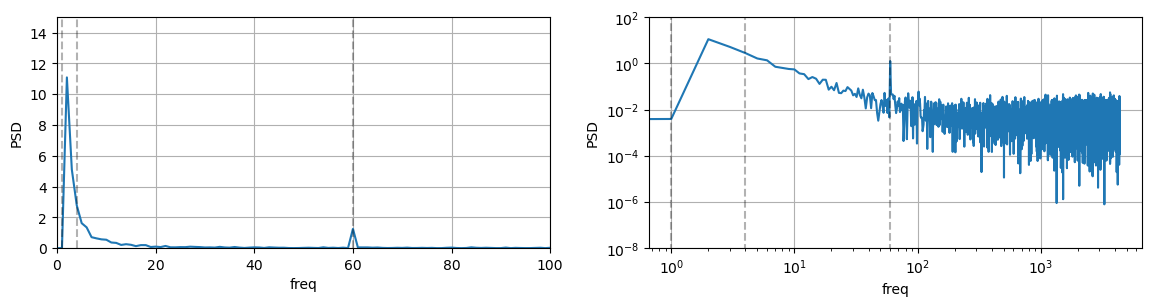

In [20]:
# get a power spectrum density and associated frequencies, and do a plot (linear and log)

freq, psd = signal.periodogram(f_vec)

fig = plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(psd)
ax.plot([1, 1], [0, 100], 'k--', alpha=0.3)
ax.plot([4, 4], [0, 100], 'k--', alpha=0.3)
ax.plot([60, 60], [0, 100], 'k--', alpha=0.3)
ax.set_xlabel("freq")
ax.set_ylabel("PSD")
ax.set_xlim([0, 100])
ax.set_ylim([0, 15])
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.loglog(psd)
ax.loglog([1, 1], [0, 100], 'k--', alpha=0.3)
ax.loglog([4, 4], [0, 100], 'k--', alpha=0.3)
ax.loglog([60, 60], [0, 100], 'k--', alpha=0.3)
ax.set_ylim([1e-8, 1e2])
ax.set_xlabel("freq")
ax.set_ylabel("PSD")
ax.grid()

So some comments both good and bad/unexpected:

* There is a peak in the PSD corresponding to `60` which is very visible (more so in graph using logscales). A distinct peak in the PSD then corresponds to an oscillation at the corresponding frequency.
* There is a peak at smaller frequencies, but these don't quite correspond to `1` or `4`?

There are several reasons for this, the most notable one being the presence of non-oscillatory terms. What we want is to get rid of the non-oscilltory terms. 

> NOTE: The above reason is "obvious" if we talked about Fourier transforms and spectral representations, but just take my word for it if not. These non-oscillatory terms essentially all get dumped into the zero frequency case.

In this case we have the original signal so we could have just commented out the things that clearly do not contribute to an oscillation (the linear and the constant term; we can't say anything about the noise because it's random, so for all you know it could have randomly got some oscillations at isolated moments in time). 

Another is to **detrend** the data. From visually inspecting the data it looks like it has a linear trend, so we can try removing that first: do a linear regression on the data, then remove the data relative to that regressed result. Below code does that and then generates the PSD plots again, using `scipy.signal.detrend`. I am additionally going to get rid of the `0` entry in `psd` because `0` doesn't correspond to oscillations anyway.

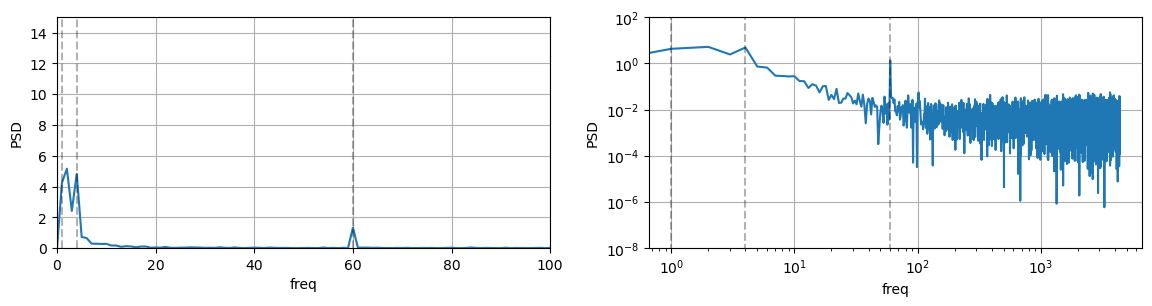

In [21]:
# detrend then do PSD again

f_mod = signal.detrend(f_vec, type="linear")

freq, psd = signal.periodogram(f_mod)
psd[0] = 0.0

fig = plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(psd)
ax.plot([1, 1], [0, 100], 'k--', alpha=0.3)
ax.plot([4, 4], [0, 100], 'k--', alpha=0.3)
ax.plot([60, 60], [0, 100], 'k--', alpha=0.3)
ax.set_xlabel("freq")
ax.set_ylabel("PSD")
ax.set_xlim([0, 100])
ax.set_ylim([0, 15])
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.loglog(psd)
ax.loglog([1, 1], [0, 100], 'k--', alpha=0.3)
ax.loglog([4, 4], [0, 100], 'k--', alpha=0.3)
ax.loglog([60, 60], [0, 100], 'k--', alpha=0.3)
ax.set_ylim([1e-8, 1e2])
ax.set_xlabel("freq")
ax.set_ylabel("PSD")
ax.grid()

Now we get the `4` coming out, although the `1` is not. Part of the reason is that the `1` signal is too close to `0` and the computation just doesn't come out very well it turns out (it is what it is as in most cases with realistic data).

Now we want to try and do this "properly" and give the frequency in useful units. If you simply to e.g. `ax.plot(freq, psd)` you will find the frequencies seem to have no correspondence to things you have. The two reasons are

* I haven't specified the sampling rate `fs` properly yet, which is in units of 1/time
* I am also working in weird units of time at the moment

Fixing the second should fix the first also. Now this bit gets bit convoluted (but it really is just change of units). Taking the frequency `1` case as an example, note that (easy but less robust explanation first):

* Because I took my code time length to be from $t=0$ to $t=2\pi$, $f=1$ here corresponds to 1 oscillation over the whole period. The whole period I created to mean $2$ years, so $f=1$ corresponds to a period of $2$ years. So this arises because I was quite inconsistent in choosing units for time when I made the original notebook a few years ago (I got confused as to what was going on...)

* Alternatively, I am really measuring my time in units of 2 years (!!!), and what I really have something is an oscillation described by $\sin(2\pi f t)$, where $f$ is my frequency. Frequency has units of $1 / \mathrm{time} = 1 / 2 \mathrm{years}$ in this case. $2\pi$ means 1 cycle, so $\omega = 2\pi f$ is in units of $\mathrm{cycles} / 2 \mathrm{years}$, so above really corresponds to one cycle every two years.

The main upshot is that I should have oscillations at 2 years, half a year (because $2\ \mathrm{years} = 4 \times 0.5\ \mathrm{years}$), and roughly every $1/30$ year. In days, this is roughly 720, 180 and 12 days.

If I decide to my units in "years", since I created the above signal with a spacing of 2 hours, and we have $1\ \mathrm{hour} = 1 / 24\ \mathrm{day} \approx 1 / 24 / 360\ \mathrm{year}$. Thus $2\ \mathrm{hours} = (2 / 8640)\ \mathrm{years}$, but the routine wants `fs` as a ***sampling rate*** (which has units of per time), so we want to flip that upside down, i.e. sampling rate is $8640 / 2 = 4320\ \mathrm{year}^{-1}$. The corresponding frequencies of the oscillations we put in should thus be $1/2 = 0.5$, $1/0.5 = 2.0$ and $1/(1/30) = 30.0$.

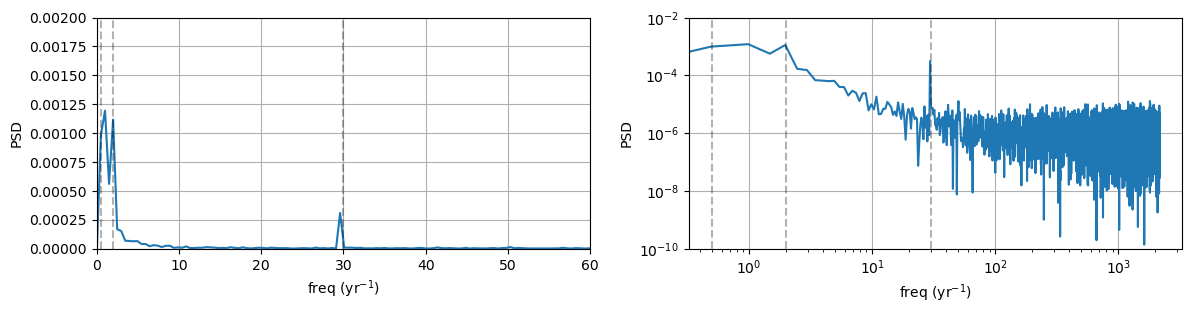

In [22]:
# detrend then do PSD again

f_mod = signal.detrend(f_vec, type="linear")

freq, psd = signal.periodogram(f_mod, fs=4320)
psd[0] = 0.0

fig = plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(freq, psd)
ax.plot([0.5, 0.5], [0, 100], 'k--', alpha=0.3)
ax.plot([2.0, 2.0], [0, 100], 'k--', alpha=0.3)
ax.plot([30.0, 30.0], [0, 100], 'k--', alpha=0.3)
ax.set_xlabel("freq ($\mathrm{yr}^{-1}$)")
ax.set_ylabel("PSD")
ax.set_xlim([0, 60])
ax.set_ylim([0, 2e-3])
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.loglog(freq, psd)
ax.loglog([0.5, 0.5], [0, 100], 'k--', alpha=0.3)
ax.loglog([2.0, 2.0], [0, 100], 'k--', alpha=0.3)
ax.loglog([30.0, 30.0], [0, 100], 'k--', alpha=0.3)
ax.set_ylim([1e-10, 1e-2])
ax.set_xlabel(r"freq ($\mathrm{yr}^{-1}$)")
ax.set_ylabel("PSD")
ax.grid()

Notice the graph limits have changed, which is related to the normalisation factor (which depends on the sampling rate in this routine); here we don't care particularly because we are only looking for peaks, and the normalisation shifts everything up or down. 

Below does this when our time units are in "days". Convince yourself I should have `fs = 12` and my peaks should be located at $1/720$, $1/180$ and $1/12$.

> NOTE: The slight offsets in the peaks are probably because I took 360 days to be a year for simplicity.

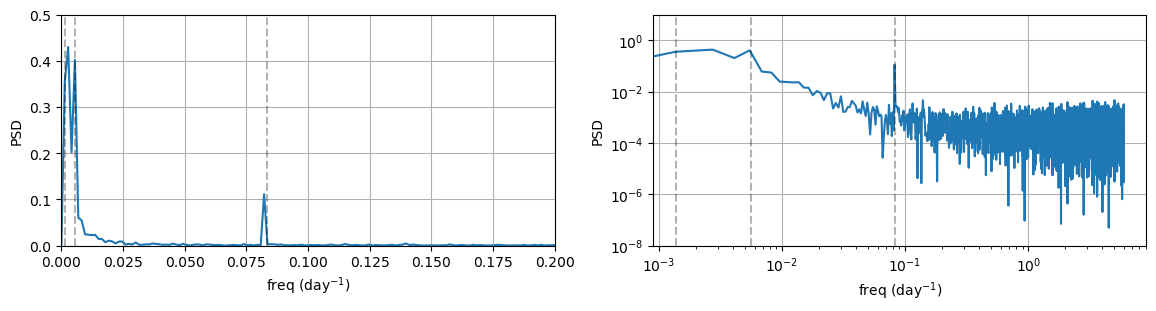

In [23]:
# detrend then do PSD again

f_mod = signal.detrend(f_vec, type="linear")

freq, psd = signal.periodogram(f_mod, fs=12)
psd[0] = 0.0

fig = plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(freq, psd)
ax.plot([1/720.0, 1/720.0], [0, 100], 'k--', alpha=0.3)
ax.plot([1/180, 1/180.0], [0, 100], 'k--', alpha=0.3)
ax.plot([1/12.0, 1/12.0], [0, 100], 'k--', alpha=0.3)
ax.set_xlabel("freq ($\mathrm{day}^{-1}$)")
ax.set_ylabel("PSD")
ax.set_xlim([0, 0.2])
ax.set_ylim([0, 5e-1])
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.loglog(freq, psd)
ax.plot([1/720.0, 1/720.0], [0, 100], 'k--', alpha=0.3)
ax.plot([1/180, 1/180.0], [0, 100], 'k--', alpha=0.3)
ax.plot([1/12.0, 1/12.0], [0, 100], 'k--', alpha=0.3)
ax.set_ylim([1e-8, 1e1])
ax.set_xlabel(r"freq ($\mathrm{day}^{-1}$)")
ax.set_ylabel("PSD")
ax.grid()

> <span style="color:red">**Q.**</span> Compute the PSDs again but by modifying the original `f_vec` directly, commenting out all the non-oscillations and/or the noise, and see if that helps.

----------------------
# e) Application to El-Nino 3.4 data

Just going to throw the tools we used above at the El-Nino 3.4 data. We read the data first. I am also going to make a raw number version of the time array instead of using datetime, because I want the raw numbers (e.g. to compute linear trends).

In [24]:
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    f = open("elnino34_sst.data", "r")
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/elnino34_sst.data"
    f = urllib.request.urlopen(path)
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

elnino34_txt = f.readlines()
elnino34_txt = elnino34_txt[3:-4]
for k in range(len(elnino34_txt)):
    if type(elnino34_txt[k]) == str:
        elnino34_txt[k] = elnino34_txt[k].strip("\n")
    elif type(elnino34_txt[k]) == bytes:
        elnino34_txt[k] = elnino34_txt[k].decode("utf-8").strip("\n")

elnino34_txt[0].split()

elnino34_sst = []
for k in range(len(elnino34_txt)):           # this is the new elnino34_txt after stripping out some lines
    dummy = elnino34_txt[k].split()          # split out the entries per line
    for i in range(1, len(dummy)):           # cycle through the dummy list but skip the first entry
        elnino34_sst.append(float(dummy[i])) # turn string into a float, then add to list

elnino34_sst = np.array(elnino34_sst)

# I want to do sums on this so I am going to use the raw version 
# (I personally find the numbers easier to manipulate)
t_vec = np.linspace(1950, 2019+1, len(elnino34_sst), endpoint=False)

loading data remotely


We plot the time-series data below and compute the linear trend (through standard `np.polyfit`, but you can use something else). Note that the trend here is per **years**, because I made the time array in units of years.

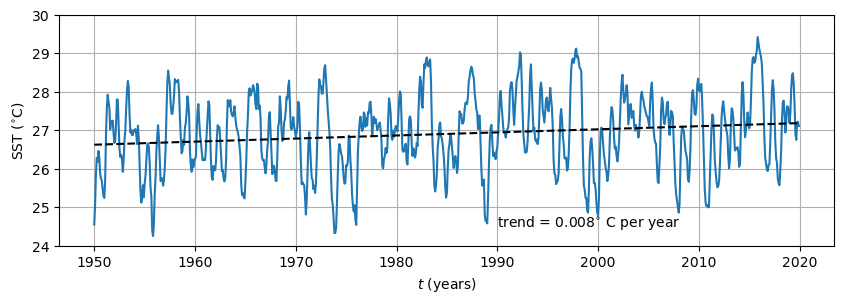

In [25]:
p = np.polyfit(t_vec, elnino34_sst, 1)
lin_trend = p[0] * t_vec + p[1]

fig = plt.figure(figsize=(10, 3))
ax = plt.axes()
ax.plot(t_vec, elnino34_sst, 'C0')
ax.plot(t_vec, lin_trend, 'k--')
ax.text(1990, 24.5, f"trend = ${p[0]:.3f}^{{\circ}}\ \mathrm{{C}}$ per year", color="k")
ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"SST (${}^{\circ}\mathrm{C}$)")
ax.set_ylim(24, 30)
ax.grid()

> <span style="color:red">**Q.**</span> What does the trend mean here? Is this physically consistent with what is know? (You might need to look this up.)

We can pass the raw signal through a filter to smooth out some of the oscillations to help us pick out the longer oscillations. I am going to use a Gaussian filter with varying windows here, but you can try use something else (e.g. rolling average, a tent-like kernel, or otherwise).

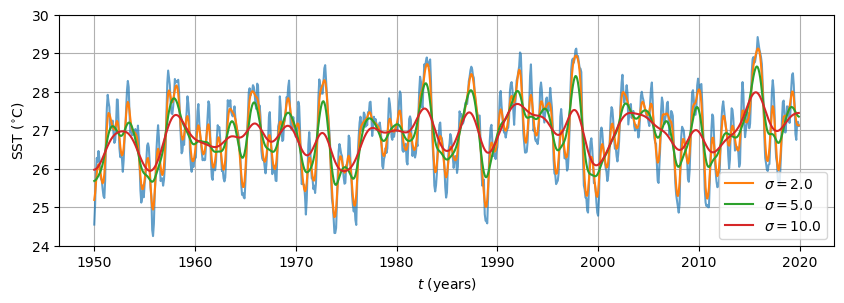

In [26]:
fig = plt.figure(figsize=(10, 3))
ax = plt.axes()

ax.plot(t_vec, elnino34_sst, alpha=0.7)

sigma_vec = [2.0, 5.0, 10.0]

for sigma in sigma_vec:
    elnino34_gauss = gaussian_filter(elnino34_sst, sigma)
    ax.plot(t_vec, elnino34_gauss, label=f"$\sigma = {sigma}$")
ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"SST (${}^{\circ}\mathrm{C}$)")
ax.set_ylim(24, 30)
ax.grid()
ax.legend()

The $\sigma = 10$ case, while averaging quite hard and reducing the magnitudes, is really pulling out the longer oscillations, which by eye we can pick out to be around 2 to 7 years. We can quantify this better with another method in *08_time_series*.

> <span style="color:red">**Q.**</span> Do a low pass of the signal for a specified window of 6 months, 2 years and 10 years, and describe signal, with both a not weighted and weighted (e.g. tent kernel) options.

I am going to calculate an ACF via the way I did it above. If you use the acf function from `statsmodel` you will get a qualitatively similar behaviour at the beginning, but something different beyond about 6 months.

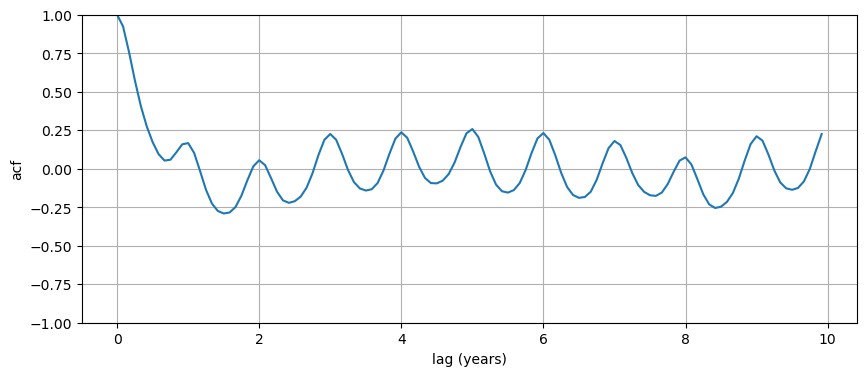

In [27]:
dt = np.diff(t_vec)[0]

f_vec = pd.Series(elnino34_sst)
n = 12 * 10  # this would be 10 years

acf = np.zeros(n)
for lag in range(n):
    acf[lag] = f_vec.autocorr(lag=lag)

fig = plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.plot(np.arange(n) * dt, acf)
ax.set_ylim([-1, 1])
ax.set_ylabel(r"acf")
ax.set_xlabel(r"lag (years)")
ax.grid()

> <span style="color:red">**Q.**</span> How fast does the signal lose predictability in some sense?

> <span style="color:red">**Q.**</span> Normally we might expect once the signal loses predictability you might think that's it. However, there are oscillations persisting after that initial drop. What might be the physical cause of this?

> <span style="color:red">**Q.**</span> Investigate what happens if you compute the ACF like above *after* you low-pass the signal. Consider different sized windows.

> <span style="color:red">**Q.**</span> (Harder and more involved) Here we used the whole time-series, but suppose you chop up the data in multiple chunks (say 20 year windows, shifted per year), and you repeat the acf analysis. Investigate if there are certain instance of periods of time (e.g. say during an El-Nino year) with a significantly different acf compared to the "normal", just by eye. Consider how you might do this statistically.
>
> (I don't precisely know what the acf in `statsmodel` does, but I have a suspicion if this is what it is doing. Given the lag, you chop up the regions and perform an analysis on all the sub-samples, and then compute the statistics of the acf. This is one reason I am not using it, because I don't really know what it is doing...)

> <span style="color:red">**Q.**</span> (Harder and more involved) As above, but consider say a 2 year period instead, and see if there changes in the "predictability" as suggested by the acf during El-Nino years. You will need to have a way to distinguish what constitutes an El-Nino year; usually this is done "by above average temperatures" over some threshold, i.e. large enough anomalies, but in this case you need the anomalies relative to the linear trend probably.

Here we compute the PSD, being careful with units of time. I have also done some other cosmetic things that I will not elaborate on; go through the lines of code to see what is going on, and convince yourself what I did below is sensible (I'm going to do this with the `f_vec` that is now a `pandas` series, to show in this case you can usually throw those into `numpy` and `scipy` routines as if they are the usual arrays).

One main point that can be taken away from the graph below is that there is quite a lot of power in the 2 to 7 year range, indicating an oscillation that is predominantly over this range; this roughly corresponds to what we know about El-Nino.

/tmp/ipykernel_2776021/2556052934.py:9: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1/freq, psd)


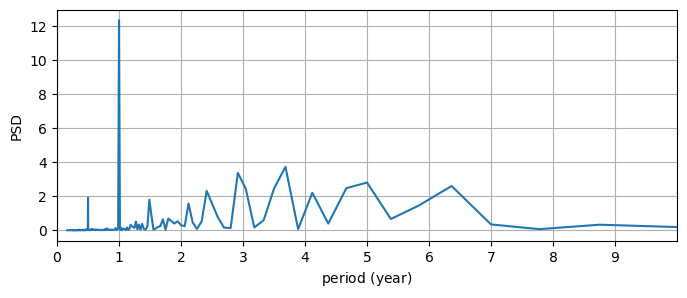

In [28]:
# detrend then do PSD again

freq, psd = signal.periodogram(f_vec, fs=12)
psd[0] = 0.0

fig = plt.figure(figsize=(8, 3))

ax = plt.axes()
ax.plot(1/freq, psd)
ax.set_xlim([0, 10])
ax.set_xticks(np.arange(10))
ax.set_xlabel(r"period ($\mathrm{year}$)")
ax.set_ylabel("PSD")
ax.grid()

> <span style="color:red">**Q.**</span> Why did I take `fs=12`?

> <span style="color:red">**Q.**</span> Why can I show things in this case in terms of "periods" instead of "frequencies", like in the PSDs I computed above?

> <span style="color:red">**Q.**</span> You should get an error above about dividing by zero. What is going on? Even though it doesn't actually matter in this case, try and patch up the way the calculations are being done so there is no division by zero. (hint: related to question before)

> <span style="color:red">**Q.**</span> There is a massive peak that I have basically ignored. What does it represent physically, and why might be justified that I just ignored it? (hint: what's the corresponding period?)

> <span style="color:red">**Q.**</span> (Slightly harder) What about the peak to the left of that massive peak I am referring to above? Why is it there? (hint: probably related to "aliasing"; argue whether this causes an issue for the higher multiples of the periods)

> <span style="color:red">**Q.**</span> Show the above PSD with period in units of months and/or days as a practice (I would make a copy of the cell so you don't modify what is already "correct").

----------------
# More involved exercises with this notebook

## 1) Pandas

Of course `pandas` have some of the functionality described above built in already, and remote loading is also builtin particularly for text files (in a less janky way than the one I did). Try look some of these up and reproduce some of the above within `pandas` (e.g., `.mean`, `.sum`, `.rolling`, etc.)

## 2) El-Nino biogeochemistry data

In `elnino34_bgc.data` is a processed reanalysis product of chlorophyll concentration as well as phytoplankton concentration, spatially averaged over the El-Nino 3.4 region; look up the raw data itself for units and the extend of time period (note that the El-Nino 3.4 SST data is monthly averaged, but spans Jan 1950 to Dec 2019).

Do a similar analysis on this data, but also do some cross-correlations of the the three signals you now have (SST, chl-$a$ concentration and phytoplankton concentration) over the overlapping periods. Interpret the data accordingly, and see if you can do some physical rationalisations of the data. 

Consider doing some hypothesis testing too (e.g. El-Nino years cause a decrease in biological activity in the region); you may need to pull out or generate your own samples. Be careful with formulating your null hypothesis, choice of significance, interpretation of the conclusions, and so forth.

In [29]:
# pull or open files from the internet if needed (e.g. temporary session in Colab)
# link = https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/main/elnino34_bgc.data

## 3) Window functions

[**Window functions**](https://en.wikipedia.org/wiki/Window_function) are really intended to be used to modify a signal to force it to be periodic, so that you can do Fourier analysis on it; see *08_time_series*. While they are not designed as kernels functions, there is no particularly reason you can't use them as kernel functions for filtering. Two exercises to try here:

1) Choose a window (`signal.tukey` is as good a choice as any), look up the syntax and plot out the window function. What you then want to do is to normalise the kernel function so that the integral of the window function is 1 (hint: you probably want `np.trapz` somewhere to do the integral). Then, one option is to multiply the kernel function by the window size, multiply that scaled kernel function to a uniformly spaced signal, then compute the mean as in the filtering cases above to give you a value of the filtered function at some $t$. Because you multiply the intended kernel function by window size and then compute the mean of the product, you are preserving the magnitude of the function somewhat (if you miss one of these steps then the result will either be too large or too small). Try different choices of window sizes.

2) Try other functions available in `scipy.signal` and see if there are any significant differences. Some of these windows have parameters associated with them (e.g. `signal.tukey` has an optional `alpha` parameter), look and see what differences those make too.

It doesn't matter which signal you use on. Use the ones provides above or make your own up.

## 4) [Wavelets](https://en.wikipedia.org/wiki/Wavelet)

**Wavelets** are a particular class of functions that can also serve as a basis, like Fourier modes (see the old *08_time_series*). You may or may not want to look up what wavelets are, and consider using the `pywt` package (which is external, so you might need to `conda` or `pip` it). One thing you could try here is to use wavelets as a way to filter noisy signals, as in the exercise above.

If you want more info, one place I recommend looking into is Jonathan Lilly's [time-series course](https://github.com/jonathanlilly/time-series), which is much more advanced and much more thorough than the things I have here.

> NOTE: To use Jonathan's material, either download the whole pack or `git clone` the pack, and open `index.html` in the downloaded folder in your browser.